# **Tarea 2 Inteligencia artificial**

## **a) Investigación Extended Kalman Filters (EKF) y Unscented Kalman Filters (UKF)**





Para hablar de EKF y UKF primero se debe considerar que es un Filtro de Kalman. Un Filtro de Kalman es un algoritmo que permite estimar variables de estado ocultas a partir de variables observables que pueden contener algún error de medición, aplicado a modelos ocultos de Markov. En otras palabras un Filtro de Kalman es una herramienta para predecir valores usando un montón de ecuaciones matemáticas bajo el supuesto de que nuestros datos están en forma de distribución gaussiana y aplicamos ecuaciones lineales a esa distribución gaussiana.

El problema con los Filtros de Kalman es que sólo trabajan para funciones lineales, y en la realidad muchos sistemas se modelan gracias a funciones no lineales. Es por esto que existen los Extended Kalman Filters que usan series de Taylor y la matriz Jaboiana para obtener una aproximación lineal de la función no lineal a través de la media Gaussiana, logrando así trabajar para modelos no lineales. 

Los Extended Kalman Filters también tienen problemas, pues tienen un alto costo computacional cuando el grado de no linealidad es grande. Entonces para ello existen los Unscented Kalman Filters. Cuando usamos EKF hacemos una aproximación basada en la media Gaussiana, digamos que esta es una aproximación basada en un punto, lo cual se vería de la siguiente manera:


<p align="center" width="100%">
    <img width="33%" src="EKF.png">
</p>

En cambio en UKF se toman un montón de puntos llamados puntos sigma y se aproxima. Cuanto mayor sea el número de puntos, más precisa será nuestra aproximación. El diagrama para UKF es el siguiente:

<p align="center" width="100%">
    <img width="33%" src="UKF.png">
</p>

De manera resumida, los pasos para usar UKF serían los siguientes:

1. Calcular un conjunto de puntos sigma.
2. Asignar pesos a cada punto sigma.
3. Transformar los puntos a través de una función no lineal.
4. Calcular gaussiana a partir de puntos ponderados y transformados.
5. Calcular media y varianza de la nueva Gaussiana.




## **b) y c) Gráficas para aprecias impacto de los sensores**

El siguiente código muestra gráficos de la posición real y de la posición estimada del submarino. Se puede apreciar como la estimada tiende a la real a medida que se avanza en los gráficos.

Las iteraciones graficadas serán 0, 20, 30 y 47. Así es posible apreciar una evolución en la estimación, donde 0 es el inicio y 47 el final.

### CASO 1 - Usando los 3 tipos de sensores: IMU, compás y encoders

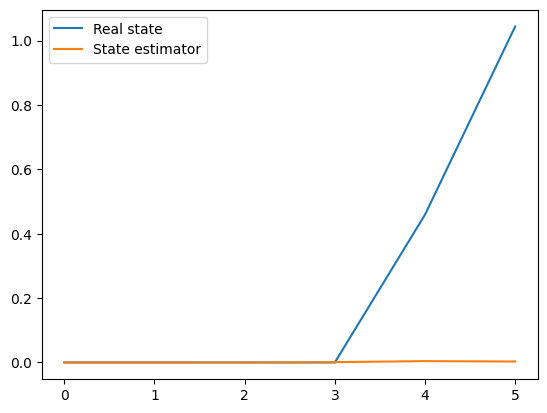

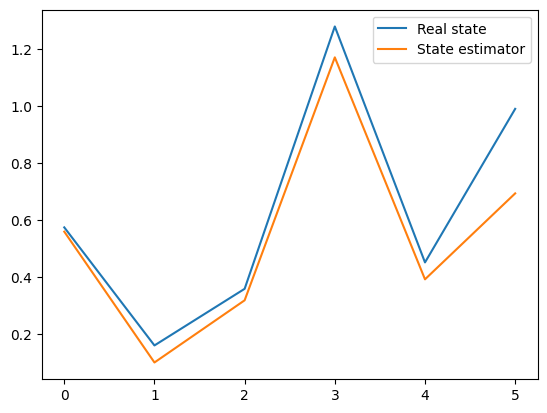

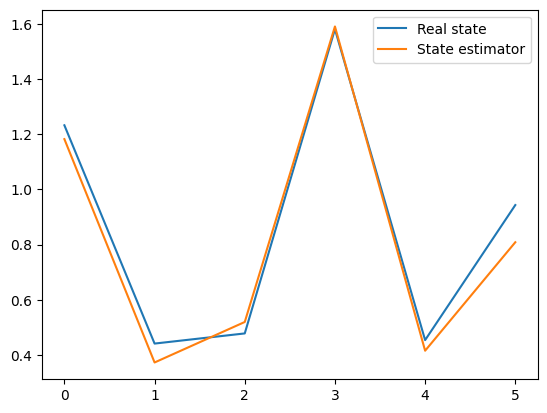

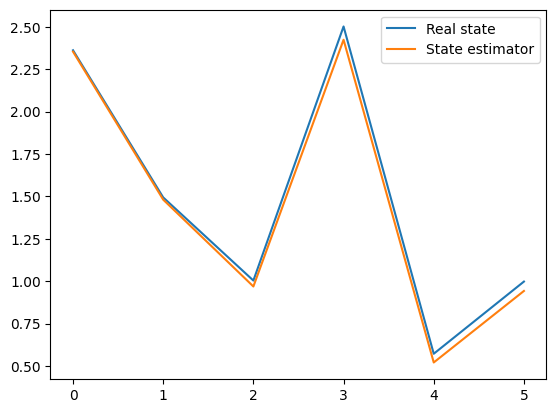

Difference:  [0.008 0.013 0.035 0.078 0.051 0.055]


In [59]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()


### CASO 2 - Sólo con IMU (Inertial Measurement Unit)

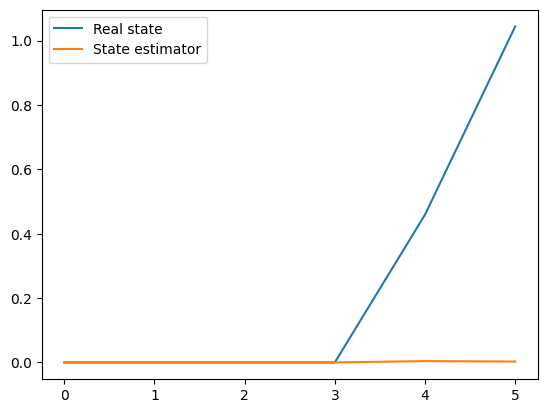

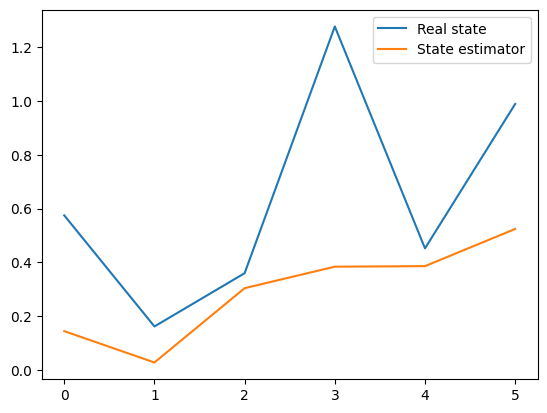

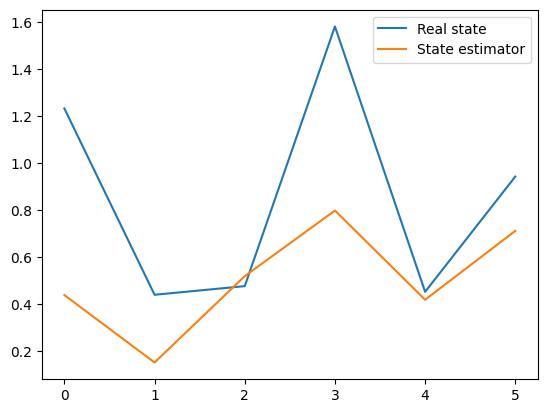

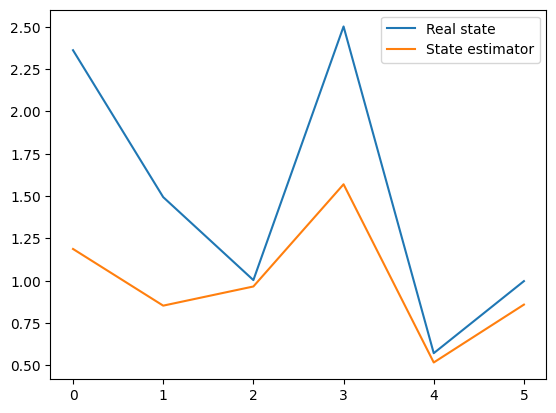

Difference:  [1.174 0.641 0.038 0.932 0.055 0.139]


In [60]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
           # state_estimator.update([2], compass_data, r_compass)
           # state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

            #print("contador: ", i)
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i +=1

if __name__ == "__main__":
    main()


### CASO 3 - Sólo con compás

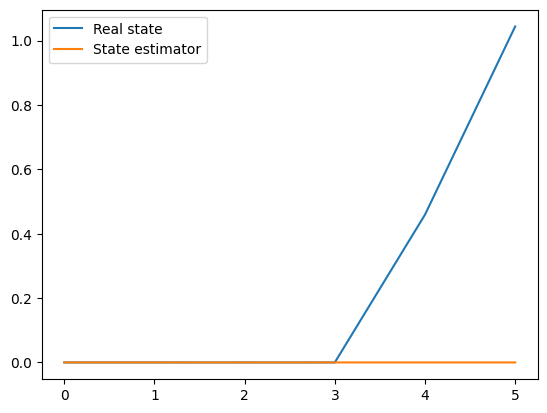

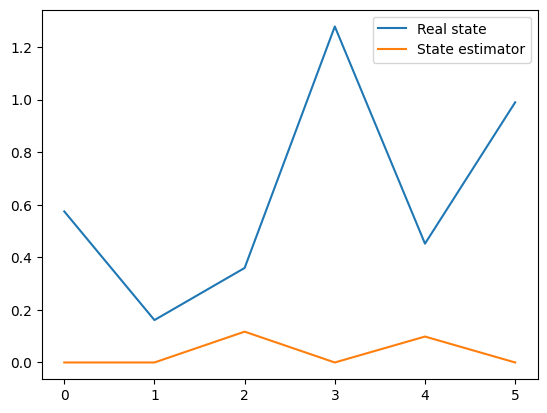

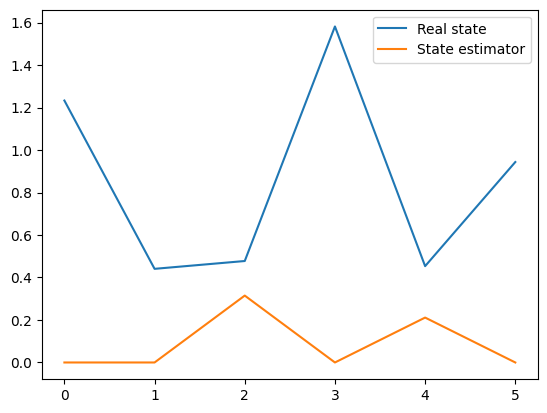

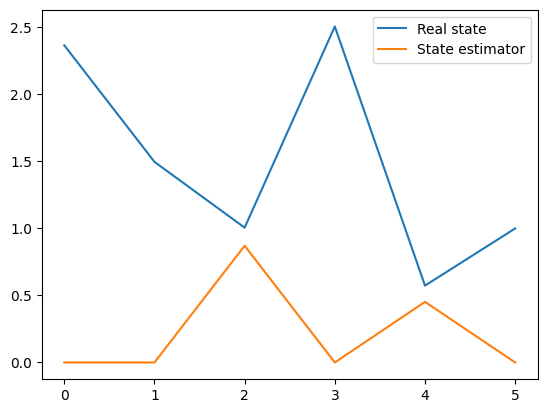

Difference:  [2.362 1.494 0.135 2.502 0.121 0.998]


In [61]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
           # state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
           # state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

            
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i +=1

if __name__ == "__main__":
    main()

### CASO 4 - Sólo con encoders

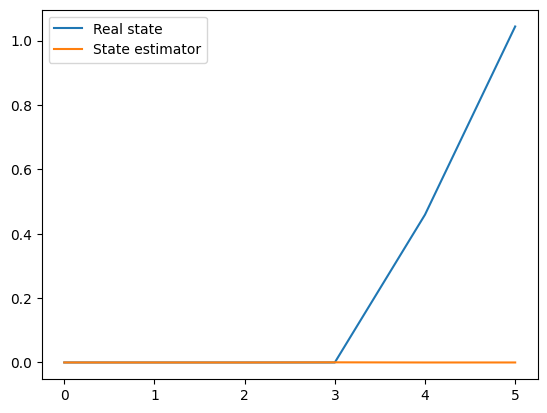

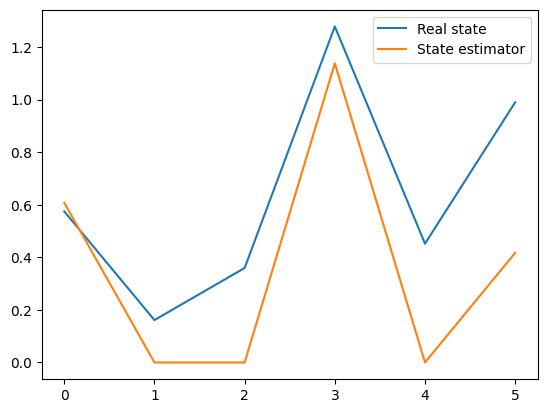

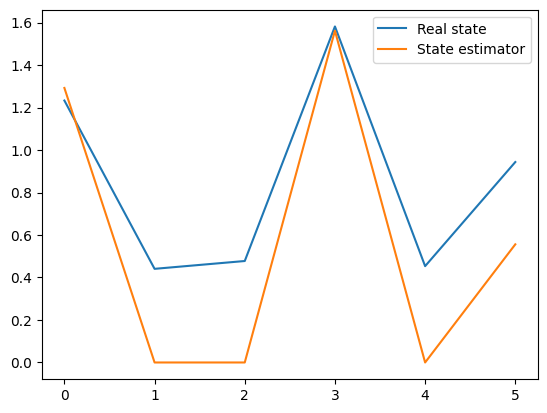

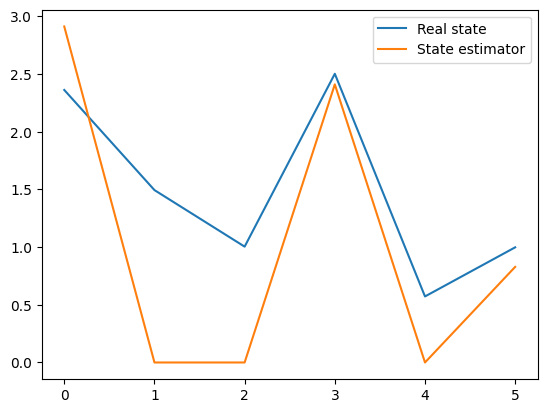

Difference:  [-0.55   1.494  1.004  0.092  0.572  0.169]


In [62]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
           # state_estimator.update([4, 5], imu_data, r_imu)
           # state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

            
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i +=1

if __name__ == "__main__":
    main()

### CASO 5 - Con IMU y Compás

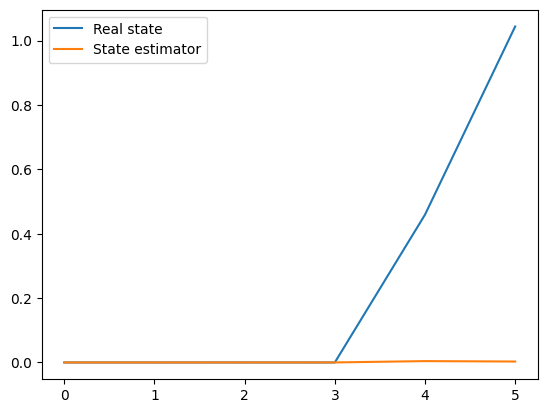

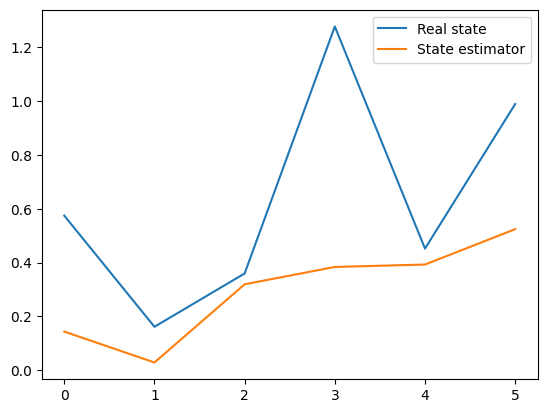

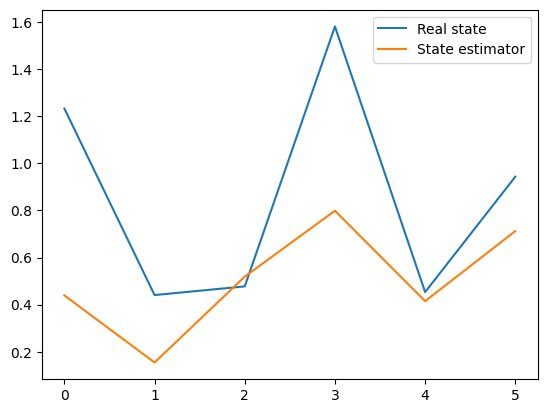

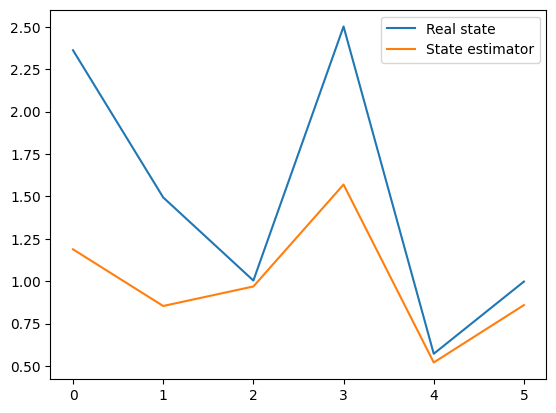

Difference:  [1.174 0.64  0.035 0.932 0.051 0.139]


In [63]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            #state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### CASO 6 - Con IMU y encoders

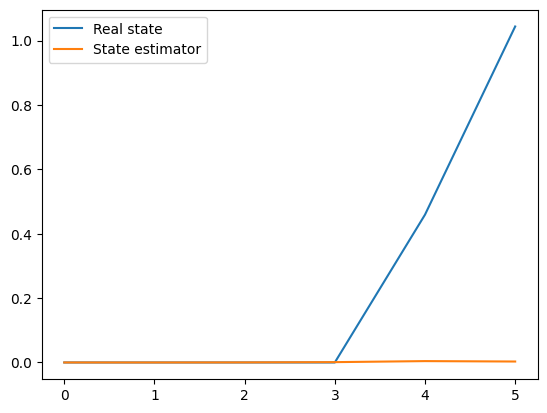

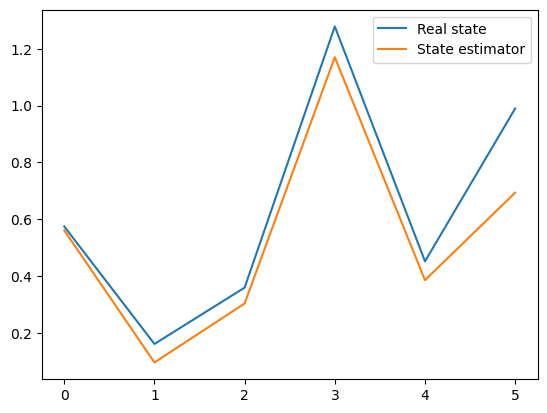

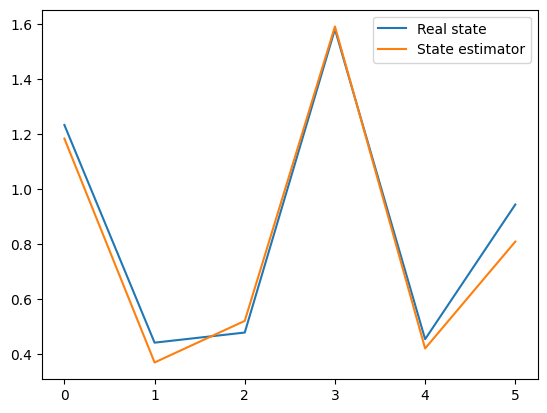

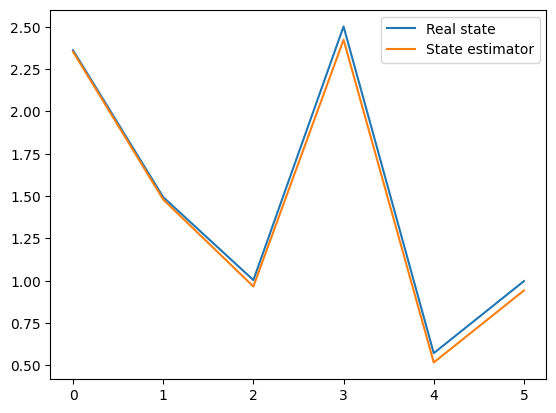

Difference:  [0.009 0.014 0.038 0.078 0.055 0.055]


In [64]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            #state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### CASO 7 - Con compás y encoders

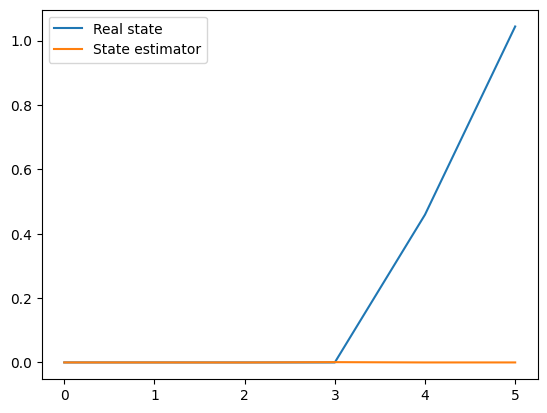

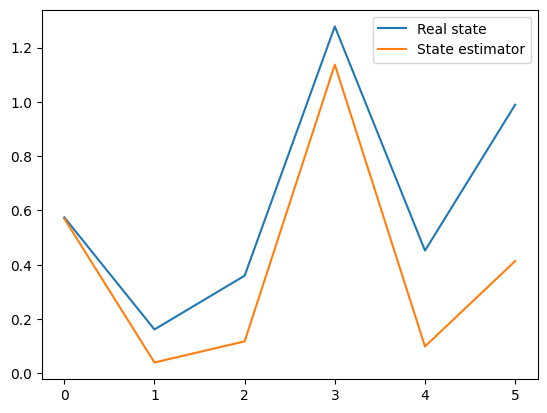

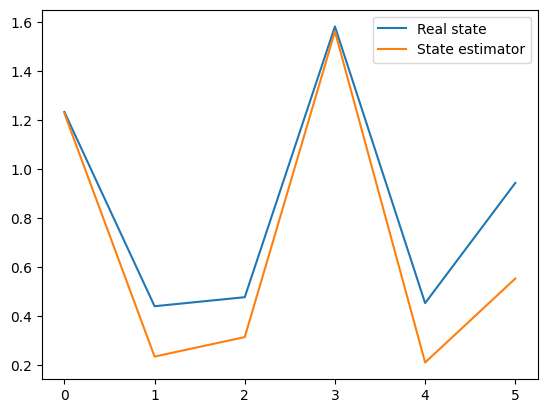

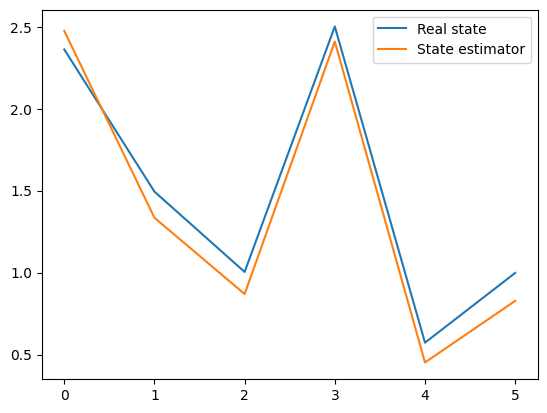

Difference:  [-0.113  0.159  0.135  0.092  0.121  0.171]


In [65]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            #state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### **Comparaciones de las diferentes situaciones respecto a la posicion real del robot**

Cuando se usan los 3 sensores para estimar la posición real del robot, se obtiene una estimación bastante precisa. Con una diferencia final con los siguientes valores:

Diferencia: [0.008 0.013 0.035 0.078 0.051 0.055]

Y la gráfica de posoción real (Real state) a comparación de la estimación (State estimator):

<p align="center" width="100%">
    <img width="33%" src="3 sensores.png">
</p>

### **En cambio, al usar sólo 1 sensor se obtiene una estimación bastante incorrecta:**

Sólo con IMU:
<p align="center" width="100%">
    <img width="33%" src="soloIMU.png">
</p>

Diferencia: [1.174 0.641 0.038 0.932 0.055 0.139]

Sólo con compás:

<p align="center" width="100%">
    <img width="33%" src="soloCompas.png">
</p>

Diferencia: [2.362 1.494 0.135 2.502 0.121 0.998]

Sólo con encoders:

<p align="center" width="100%">
    <img width="33%" src="solo encoders.png">
</p>

Diferencia: [-0.55   1.494  1.004  0.092  0.572  0.169]

Se puede apreciar claramente como las gráficas distan mucho una de otra, además la diferencia de posición real vs estimada crece considerablemente, por lo que es fácil concluir que con menos sensores es menos fiable la estimación.


### **Combinaciones entre 2 sensores**

IMU y compás:
<p align="center" width="100%">
    <img width="33%" src="IMU y compas.png">
</p>
Diferencia: [1.174 0.64  0.035 0.932 0.051 0.139]

IMU y encoders:
<p align="center" width="100%">
    <img width="33%" src="IMU y encoders.png">
</p>
Diferencia: [0.009 0.014 0.038 0.078 0.055 0.055]

Compas y encoders:
<p align="center" width="100%">
    <img width="33%" src="compas y encoders.png">
</p>
[-0.113  0.159  0.135  0.092  0.121  0.171]

Al usar 2 sensores se puede notar una clara mejora para los casos de IMU y encoders, como también para compás y encoders. En cambio, para IMU y compás no se obtiene una mejora notable respecto a sólo usar IMU, siendo casi idéntica la diferencia a sólo usar IMU.

La combinación de 2 sensores que da mejor resultado es la de IMU y encoders, siendo muy cercana a la mustra original con 3 sensores. Visualizando nuevamente la diferencua etre la posición real vs estimada para estos dos casos, tenemos:

Diferencia 3 sensores: [0.008 0.013 0.035 0.078 0.051 0.055]
Diferencia IMU y encoders: [0.009 0.014 0.038 0.078 0.055 0.055]

Como conclusión se determina que el compás es el menos relevante de los 3 sensores, si bien aporta, es muy poco. También el mínimo de sensores para obtener una estimación con bajo margen de error es de 2 sensores, siendo los más recomendables IMU y encoders.

## **d) Impacto al aumentar covarianza del ruido**

### Caso 1 Original sin modificaciones de ruido

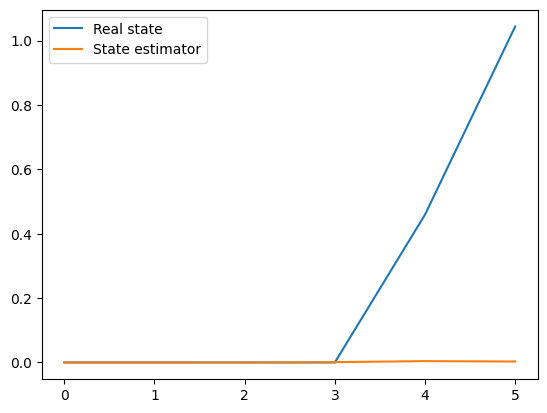

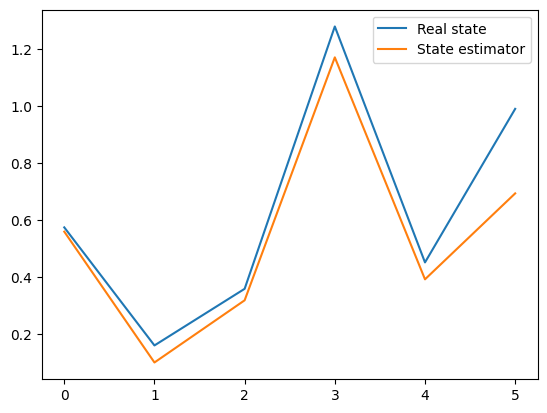

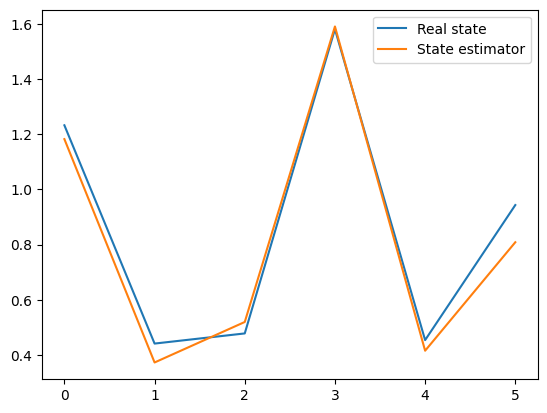

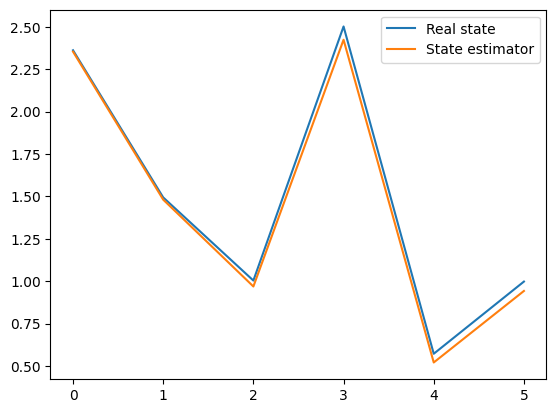

Difference:  [0.008 0.013 0.035 0.078 0.051 0.055]


In [66]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    # matriz de covarianza de ruido del modelo (?)
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # Matriz de covarianza de ruido
    # create measurement noise covariance matrices
    # cada sensor tiene su matriz de covarianza de ruido (?)
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()

### **Ahora con modificaciones de ruido**

### caso 2 Sólo IMU modificado

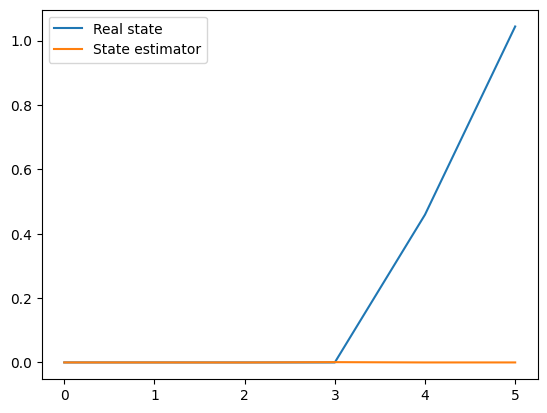

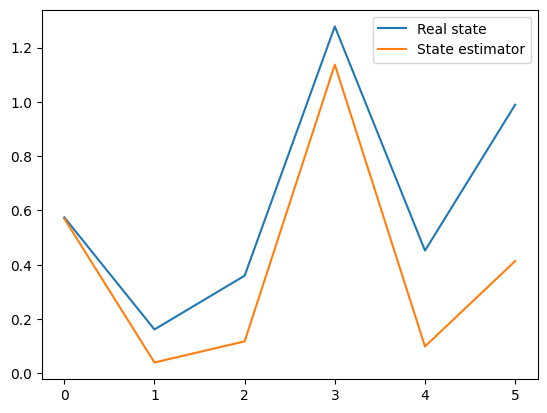

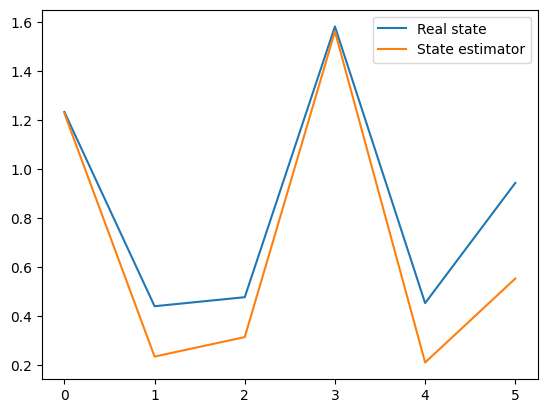

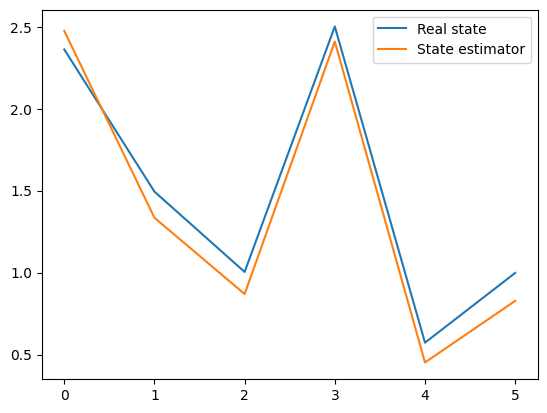

Difference:  [-0.113  0.159  0.135  0.092  0.121  0.171]


In [67]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    #r_imu[0][0] = 0.01
    #r_imu[1][1] = 0.03

    #IMU MODIFICADO
    r_imu[0][0] = 0.3
    r_imu[1][1] = 0.5

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            #state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### caso 3 Sólo compás modificado

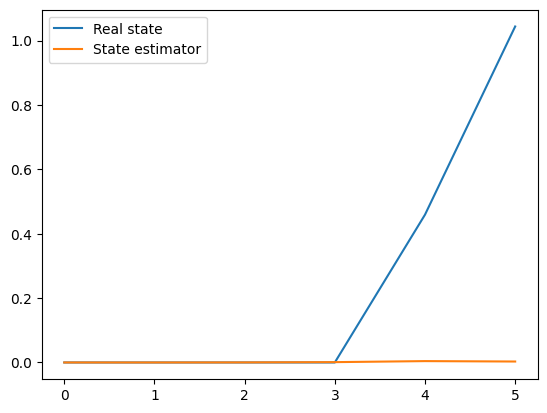

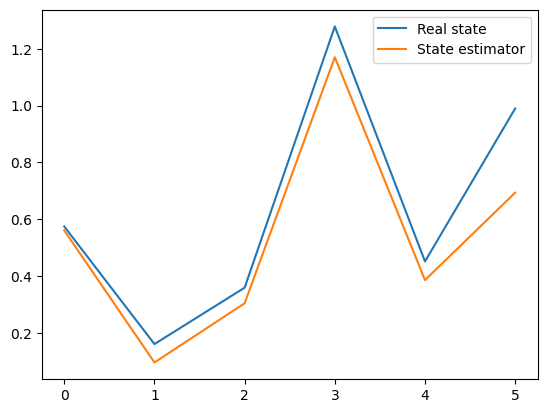

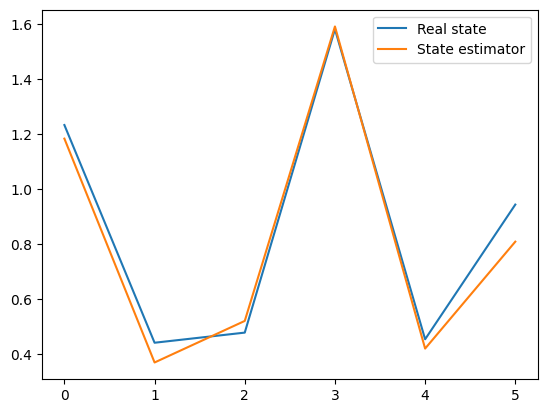

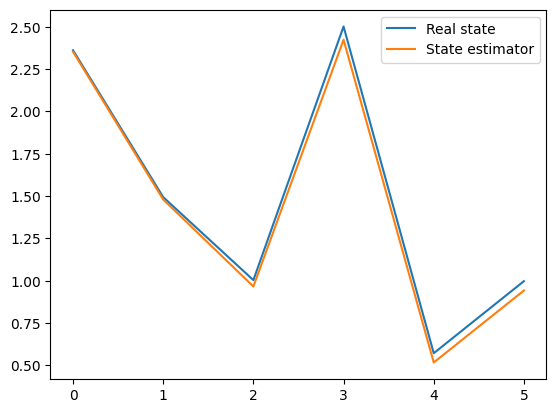

Difference:  [0.009 0.014 0.038 0.078 0.055 0.055]


In [68]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    #r_compass[0][0] = 0.02

    #Compás modificado
    r_compass[0][0] = 0.4


    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()

### caso 4 Sólo encoders modificado

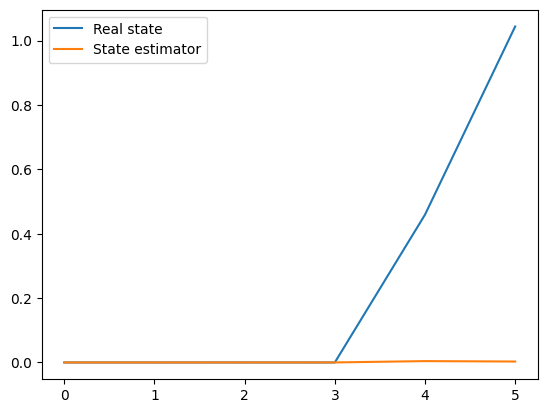

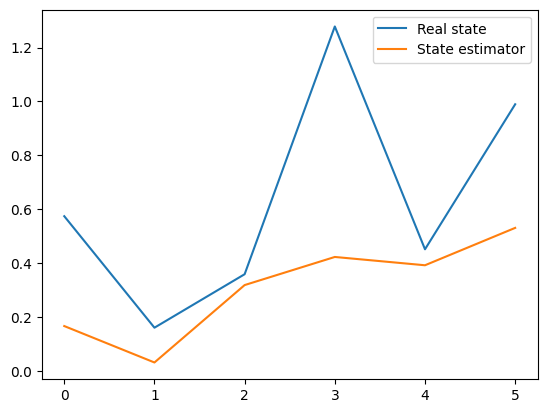

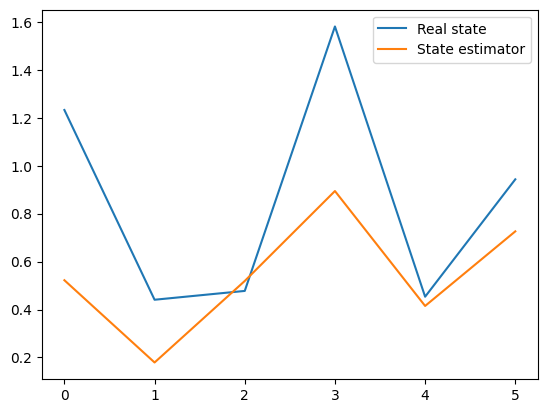

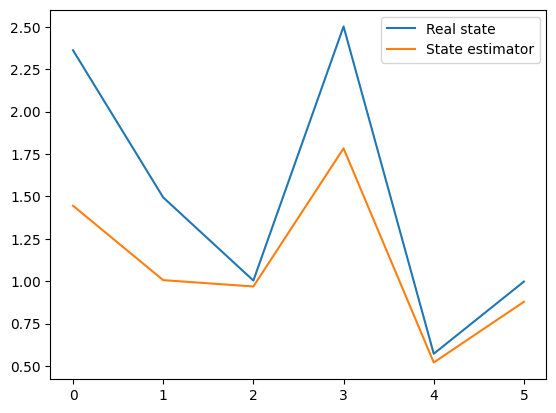

Difference:  [0.917 0.488 0.035 0.719 0.051 0.119]


In [69]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    # matriz de covarianza de ruido del modelo (?)
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # Matriz de covarianza de ruido
    # create measurement noise covariance matrices
    # cada sensor tiene su matriz de covarianza de ruido (?)
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    #r_encoder[0][0] = 0.001
    # Encoders modificados
    r_encoder[0][0] = 0.5

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()

Sólo con aumentar la covarianza de ruido de 1 sensor ya es posible apreciar un gran aumento en el error de las esimaciones, sobre todo al modificar los encoders. IMU también se ve afectado pero no en tan gran medida como encoders. Finalmente compás no tiene gran repercusión, pues como se ha estudiado antes, no afecta mucho al algoritmo.

## **Referencias**

1. Russell, S. J., &amp; Norvig, P. (2010). Artificial Intelligence: A modern approach. Prentice-Hall.

2. Wan, E. A., &amp; Van Der Merwe, R. (n.d.). The unscented Kalman filter for nonlinear estimation. Proceedings of the IEEE 2000 Adaptive Systems for Signal Processing, Communications, and Control Symposium (Cat. No.00EX373). https://doi.org/10.1109/asspcc.2000.882463 

3. Särkkä Simo. (2013). Bayesian filtering and smoothing. Cambridge Univ. Press. 